In [1]:
# Identificador da imagem a ser carregada
IMG_NUMBER = 0

In [2]:
# Imports
import cv2
from PIL import Image

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

import time

import test

cascade_classifier_path = '../env-tcc/lib/python3.6/site-packages/cv2/data/'
checkpoint_dir_path = './model_logs/release_celeba_256/'

/home/izabel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[2018-10-28 17:38:21 @__init__.py:79] Set root logger. Unset logger with neuralgym.unset_logger().
[2018-10-28 17:38:21 @__init__.py:80] Saving logging to file: neuralgym_logs/20181028173821522265.


In [3]:
# Imagem a ser carregada
source_jpg = 'img_' + str(IMG_NUMBER) + '.jpg'

# Caminho + nome da imagem original
img_filepath = './images/' + source_jpg

# Caminho + nome da mascara
mask_filepath = './masks/' + 'mask_'+ source_jpg

# Caminho + nome da imagem cortada (rosto)
img_crop_filepath = './images/' + 'crop_' + source_jpg

# Caminho + nome da imagem redimensionada (metodo linear)
img_redimen_linear_filepath = './images/' + 'redimen_linear_' + source_jpg

# Caminho + nome da imagem redimensionada (metodo cubico)
img_redimen_cubic_filepath = './images/' + 'redimen_cubic_' + source_jpg

# Caminho + nome da restauracao com OpenCV 
inpaint_opencv_filepath = './inpaints/' + 'inpaint_opencv_' + source_jpg

# Caminho + nome da restauracao com Generative Contextual Attention
inpaint_generative_filepath = './inpaints/' + 'inpaint_generative_' + source_jpg

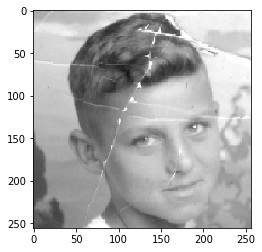

In [4]:
# Restricao de tamanho minimo 256 x 256 px e formato jpg
try:
    image = cv2.imread(img_filepath)
    height, width, channels = image.shape
    
    if (height or width) < 256:
        print('A imagem de entrada deve ter pelo menos 256 x 256 px '
              + '(imagem atual: ' + str(width) + ' x ' + str(height) + ' px)')
        image = None
        #exit()
    else:
        plt.imshow(image)
except:
    print('Imagem invalida (' + img_filepath + '). Verifique se o arquivo existe e se esta no formato .jpg')
    image = None
    #exit()

<h1>Identificação do rosto</h1>

CPU times: user 86.9 ms, sys: 3.95 ms, total: 90.8 ms
Wall time: 63.7 ms


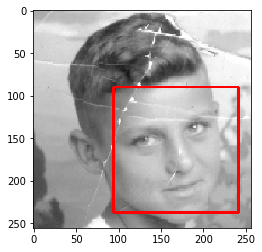

In [5]:
%%time

image_copy = cv2.imread(img_filepath)

face_cascade = cv2.CascadeClassifier(cascade_classifier_path + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cascade_classifier_path + 'haarcascade_eye.xml')

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_faces = face_cascade.detectMultiScale(image_gray, 1.3, 5)

for (x,y,w,h) in image_faces:
    cv2.rectangle(image_copy, (x,y), (x+w,y+h), (255,0,0), 2)

plt.imshow(image_copy)

<h1>Corte e redimensionamento do rosto</h1>

x: 94, x + w: 241, y: 90, y + h: 237
w: 147 h: 147


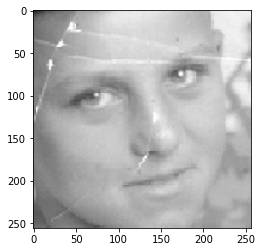

In [6]:
if len(image_faces) > 1:
    print ('A imagem deve conter apenas um rosto (qtd de rostos identificados: ' + str(len(image_faces)) + ')')
    image = None
    #exit()
else:
    x, y, w, h = image_faces[0]
    
    print('x: ' + str(x) + ', x + w: ' + str(x + w) + ', y: ' + str(y) + ', y + h: ' + str(y + h))
    print('w: ' + str(w), 'h: ' + str(h))
    
    image_cropped = image[x:x+w, y:y+h]
    cv2.imwrite(img_crop_filepath, image_cropped)
    
    img_redimen_linear = cv2.resize(image_cropped, (256, 256), interpolation = cv2.INTER_LINEAR)
    cv2.imwrite(img_redimen_linear_filepath, img_redimen_linear)
    
    img_redimen_cubic = cv2.resize(image_cropped, (256, 256), interpolation = cv2.INTER_CUBIC)
    cv2.imwrite(img_redimen_cubic_filepath, img_redimen_cubic)
    
    plt.imshow(img_redimen_cubic)
    
    face = img_redimen_cubic #img_redimen_linear
    face_filepath = img_redimen_cubic_filepath #img_redimen_linear_filepath

<h1>Identificação dos olhos</h1>

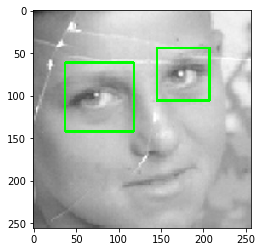

In [7]:
face_copy = cv2.imread(face_filepath)

face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
face_eyes = eye_cascade.detectMultiScale(face_gray)

if len(face_eyes) > 2:
    true_eyes = [[0, 0, 0, 0], [0, 0, 0, 0]]
    dim_eyes = [0, 0]
    
    for face_eye in face_eyes:
        curr_eye = int(((face_eye[2])**2 + (face_eye[3])**2)**(0.5))
        
        if curr_eye > max(dim_eyes):
            dim_eyes[dim_eyes.index(min(dim_eyes))] = dim_eyes[dim_eyes.index(max(dim_eyes))]
            dim_eyes[dim_eyes.index(max(dim_eyes))] = curr_eye
            true_eyes[1] = true_eyes[0]
            true_eyes[0] = face_eye
            
        elif curr_eye > min(dim_eyes):
            dim_eyes[dim_eyes.index(min(dim_eyes))] = curr_eye
            true_eyes[1] = face_eye
        else:
            pass

for (ex,ey,ew,eh) in true_eyes:
    cv2.rectangle(face_copy, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

plt.imshow(face_copy)

<h1> Criação da máscara </h1>

#TODO: Eliminar os olhos detectados no passo anterior da máscara

CPU times: user 20.8 ms, sys: 4.18 ms, total: 25 ms
Wall time: 19.2 ms


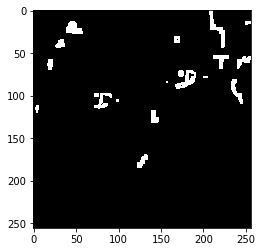

In [8]:
%%time

# Create HSV and grayscale formats
hsv = cv2.cvtColor(face, cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

# Define variables used in masking
max_gray = np.amax(gray)
min_color = np.array([0,0,max_gray-60])
max_color = np.array([255,60,max_gray])

# Create initial region mask
reg = cv2.inRange(hsv, min_color, max_color)

# plt.imshow(gray, cmap="gray")

# Blur the image for better line detection
blur = cv2.GaussianBlur(gray,(3, 3),0)

# Define morphologial transformation kernel
kernel = np.ones((3,3),np.uint8)

# Create edges and dilate to get better results
edges = cv2.Canny(gray, 100, 150)
edges = cv2.dilate(edges, kernel)

# plt.imshow(edges, cmap="gray")

# Intersect region and edges
mask = reg & edges
mask = cv2.dilate(mask, kernel)

# Save mask
cv2.imwrite(mask_filepath, mask)

plt.imshow(mask, cmap="gray")

<h1>Inpaint com Deep Generative Model with Contextual Attention</h1>

[2018-10-28 17:38:28 @gpus.py:39] Error reading GPU information, set no GPU.


Shape of image: (256, 256, 3)
Model loaded.
./inpaints/inpaint_generative_img_0.jpg
CPU times: user 5.93 s, sys: 612 ms, total: 6.55 s
Wall time: 3.38 s


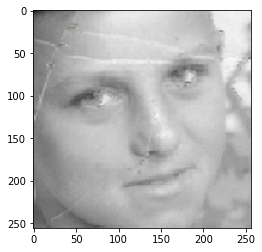

In [9]:
%%time

test.run_inpaint(image = face_filepath, 
                 mask = mask_filepath, 
                 output = inpaint_generative_filepath, 
                 checkpoint_dir = checkpoint_dir_path)

plt.imshow(np.asarray(Image.open(inpaint_generative_filepath)))
print(inpaint_generative_filepath)

<h1>Inpaint com OpenCV</h1>

./inpaints/inpaint_opencv_img_0.jpg
CPU times: user 23 ms, sys: 0 ns, total: 23 ms
Wall time: 22.5 ms


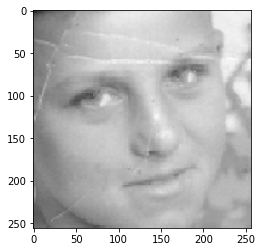

In [10]:
%%time

# face = cv2.imread(inpaint_generative_filepath)

inpaint = cv2.inpaint(face, mask, 3, cv2.INPAINT_TELEA)
save = cv2.cvtColor(inpaint, cv2.COLOR_BGR2RGB)

# Save inpaint 
cv2.imwrite(inpaint_opencv_filepath, save)

plt.imshow(inpaint)
print(inpaint_opencv_filepath)